In [1]:
# 먼저 텐서플로우 다운받고 mnist 다운받고 준비를 한다.
# 2NN 모델을 설계한다. K는 2~3개 정도만 설정 1Epoch만 돌리고 !!!Weight를 Server로 보낸다.!!! 서버는 W_(t+1)=W_t - g_k    //Fed_SGD,
# 나중에는 클라이언트에서 여러 epoch로 돌리고 Weight를 Server로 보낸다. 서버는 W_(t+1)=W_t - g_k // Fed_AVG
# 당연히 Communication cost는 AVG가 적을 것, AVG가 정확성이 따라올 수 있느냐를 중점으로 확인.
# 가장 먼저 서버모델을 만들고(이니셜라이징), 포문?(확실치 않은 이유가 포문 돌때마다 처음으로 초기화될까봐 겁남.)
# 전체 포문 안에 클라이언트1,2 돌리고 그 2개의 w를 산술평균?(일단 나중에 가중산술평균할겨) 마지막에 서버 모델 w에 덮어씌우고
# 근데 Non-IID 로 MNIST는 어떻게 나누지?

In [2]:
'''
from tensorflow.python.client import device_lib
import tensorflow as tf
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
'''
''' 8/29 
    AVG로 구현하기 dd
    1round 마다 server가 클라이언트한테 나눠주기 구현 dd
    2NN말고 CNN으로 구현하기 dd
    클라이언트가 N개일 때 자동화 어떻게 할 것인지..dd
    논문에서는 클라이언트가 100이다.dd
    MNIST 전부 분류하고 랜덤하게 몇개씩 뽑고 뽑을 때 겹치지 않게
    시각적으로 보이게 히스토그램?
    각 클라이언트들이 에포크 증가할때 정확도가 증가하는지?

'''


' 8/29 \n    AVG로 구현하기 dd\n    1round 마다 server가 클라이언트한테 나눠주기 구현 dd\n    2NN말고 CNN으로 구현하기 dd\n    클라이언트가 N개일 때 자동화 어떻게 할 것인지..dd\n    논문에서는 클라이언트가 100이다.dd\n    MNIST 전부 분류하고 랜덤하게 몇개씩 뽑고 뽑을 때 겹치지 않게\n    시각적으로 보이게 히스토그램?\n    각 클라이언트들이 에포크 증가할때 정확도가 증가하는지?\n\n'

In [3]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np

client_num=100
B_batch=600 # 배치 사이즈
C_epoch=5  # 각 클라이언트마다 몇 에포크 돌릴지
S_round=30  #총 라운드 수
#
#
#데이터(MNIST) 전처리
# MNIST 데이터를 불러옵니다.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 차원 변환 후, 테스트셋과 학습셋으로 나눔
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

##서버 모델 이니셜라이징
# 모델 구조를 설정

server_model = Sequential()
server_model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(28, 28, 1), activation='relu'))
server_model.add(Conv2D(64, (5, 5), activation='relu'))
server_model.add(MaxPooling2D(pool_size=(2,2)))
#server_model.add(Dropout(0.25))
server_model.add(Flatten())
server_model.add(Dense(10, activation='softmax'))

#서버 레이어들 정보 요약
server_model.summary()                                                

# 모델 실행 환경을 설정
server_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 최적화를 위한 설정 구간
'''serverpath="./MNIST_MLP_0.hdf5"
checkpointer = ModelCheckpoint(filepath=serverpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)'''

%load_ext memory_profiler 
%memit

# 모델 실행
server_history = server_model.fit(x_train[0:2], y_train[0:2], validation_split=0.25, epochs=1, batch_size=2, verbose=0) # 최대한 학습 안할려고 2개만 학습시킴...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                64010     
Total params: 116,106
Trainable params: 116,106
Non-trainable params: 0
_________________________________________________________________
peak memory: 1400.22 MiB, increment: 0.04 MiB


In [4]:
#클라이언트 100명 각각 설정하는 것
clients_model=[]
clients_path=[]
for i in range(client_num):
    ##클라이언트i 모델 이니셜라이징
    # 모델 구조를 설정
    clients_model.append(Sequential()) 
    clients_model[i].add(Conv2D(32, kernel_size=(5, 5), input_shape=(28, 28, 1), activation='relu'))
    clients_model[i].add(Conv2D(64, (5, 5), activation='relu'))
    clients_model[i].add(MaxPooling2D(pool_size=(2,2)))
    #clients_model[i].add(Dropout(0.25))
    clients_model[i].add(Flatten())
    clients_model[i].add(Dense(10, activation='softmax'))
    clients_model[i].summary()                                                #서버 레이어들 정보 요약
    print("@@@@@@@@@@@@@@@@")

    # 모델 실행 환경을 설정
    clients_model[i].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 모델 최적화를 위한 설정 구간
    '''clients_path.append("./MNIST_MLP_"+str(i)+".hdf5")
    checkpointer = ModelCheckpoint(filepath=clients_path[i], monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4)'''

    #처음 서버가 클라이언트한테 나눠주는 것
    array_temp=server_model.get_weights()
    clients_model[i].set_weights(array_temp)
    clients_path

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                64010     
Total params: 116,106
Trainable params: 116,106
Non-trainable params: 0
_________________________________________________________________
@@@@@@@@@@@@@@@@
Model: "sequential_2"
_________________________________________________________________
Layer (ty

In [5]:
#100명의 클라이언트 w를 산술평균해서 서버 w에 덮어 씌우기.
history_temp=[[],[]]
clients_history=[]
for i in range(0,S_round): #per round
    #각 클라이언트들마다 computations
    for j in range(client_num):#아직은 샤드2개가 아닌 300크기*2씩 준다..원래는 300짜리 다른 숫자라벨2개를 100명한테 주는거다.
        clients_history.append(clients_model[j].fit(x_train[300*2*(j):300*2*(j+1)], y_train[300*2*(j):300*2*(j+1)], validation_split=0.25, epochs=C_epoch, batch_size=B_batch, verbose=0) )
        if j%10==0:
            print(str(j)+"th client is studying")
    
    #각 클라이언트들의 w를 산술평균해서 서버에다가 주는 과정  
    array_temp = []
    for j in range(len(clients_model[0].get_weights())):
        array_temp.append(clients_model[0].get_weights()[j]/client_num)
        for k in range(1,client_num):
            array_temp[j]+=(clients_model[k].get_weights()[j])/client_num
    server_model.set_weights(array_temp)

    #1round마다 서버에 모여진 w를 다시 클라이언트한테 주는 것
    for j in range(client_num):
        clients_model[j].set_weights(array_temp)

    #서버의 1round마다의 데이터들의 히스토리를 모으는 과정
    history_temp[1].append(server_model.evaluate(x_test, y_test)[1])
    print("@@@@@"+str(i+1)+"th Round Test Accuracy: %.4f" % (history_temp[-1][-1]))
    history_temp[0].append(server_model.evaluate(x_train[0:20000], y_train[0:20000])[1])
    print("@@@@@"+str(i+1)+"th Round Train Accuracy: %.4f" % (history_temp[0][-1]))

0th client is studying
10th client is studying
20th client is studying
30th client is studying
40th client is studying
50th client is studying
60th client is studying
70th client is studying
80th client is studying
90th client is studying
313/313 [==============================] - 0s 1ms/step - loss: 1.5584 - accuracy: 0.7209
1th Test Accuracy: 0.7209
625/625 [==============================] - 1s 1ms/step - loss: 1.5729 - accuracy: 0.7124
1th Train Accuracy: 0.7124
0th client is studying
10th client is studying
20th client is studying
30th client is studying
40th client is studying
50th client is studying
60th client is studying
70th client is studying
80th client is studying
90th client is studying
313/313 [==============================] - 0s 1ms/step - loss: 0.6215 - accuracy: 0.8118
2th Test Accuracy: 0.8118
625/625 [==============================] - 1s 978us/step - loss: 0.6584 - accuracy: 0.7933
2th Train Accuracy: 0.7933
0th client is studying
10th client is studying
20th client

313/313 [==============================] - 0s 1ms/step - loss: 0.0730 - accuracy: 0.9778

 Test Accuracy: 0.9778


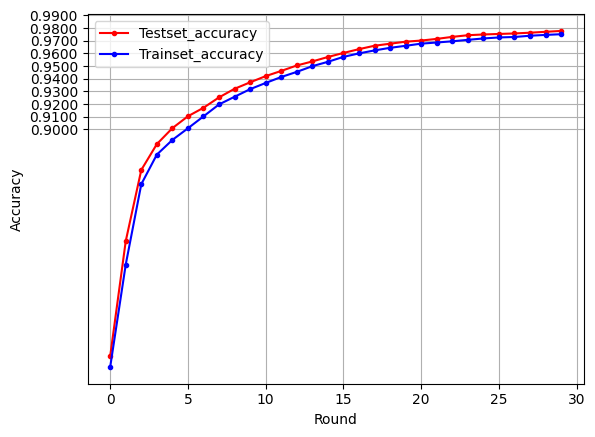

In [14]:
# 테스트 정확도
print("\n Test Accuracy: %.4f" % (server_model.evaluate(x_test, y_test)[1]))
# 검증셋과 학습셋의 오차를 저장
y_vloss = history_temp[1] #server_history.history['val_loss']
y_loss = history_temp[0]  #server_history.history['loss']

# 그래프로 표현
plt.yticks(np.arange(0.9,1,0.01))
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_accuracy')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.4f}'.format(x) for x in current_values])
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_accuracy')
# 그래프에 그리드, 레이블
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.show()

#keras model에서 가중치(weights) 가져오기

>`Model.get_weights()`

return:모델의 가중치 배열

#Keras model에 가중치(weights) 설정하기
>`Model.set_weights(weights)`

argument:
 - weights : numpy 배열의 가중치

#Keras model의 가중치(weights) 파일로 저장하기
>`Model.save_weights(filepath, overwrite=True)`

arguments:
 - filepath : 저장할 파일 경로, HDF5 형식으로 저장된다.
 - overwrite : 덮어쓰기 여부

#파일에서 Keras model 가중치(weights) 불러와 설정하기
> `Model.load_weights(filepath, by_name=False, skip_mismatch=False, reshpae=False)`

arguments:
 - filepath : 가중치 파일의 경로
 - by_name : 이름 또는 토폴로지 순서로 가중치를 로드 할지 여부를 나타낸다.
 - skip_mismath : 가중치 개수나 모양이 일치하지 않는 레이어를 건너 뛸지에 대한 여부를 나타낸다. (by_name이 True인 경우)
 - reshape : reshape 여부를 나타냄
#다른 사이트
> server_model.layers
> hidden_2 = server_model.layers[1]
> hidden_2.name
> server_model.get_layer('dense_19')
> weights, biases = hidden_2.get_weights()
> print(weights.shape)
> print(biases.shape)
> print(weights)
>print(biases)


In [7]:
#원래는 1차원 라벨을 원핫인코딩한다음 이걸 다시 원래 1차원 라벨로 변환하고 2개를 사용

#데이터 가져오기
(x_train_tmp, y_train_tmp), (x_test_tmp, y_test_tmp) = mnist.load_data()
all_x=np.concatenate([x_train_tmp, x_test_tmp], axis=0)
all_y=np.concatenate([y_train_tmp, y_test_tmp], axis=0)
# 차원 변환 후, 테스트셋과 학습셋으로 나눔
all_x = all_x.reshape(all_x.shape[0], 28, 28, 1).astype('float32') / 255
all_y = to_categorical(all_y, 10)

#print(type(x_train_tmp))

#################################################

idx = np.argsort(y_train) #idx는 
temp_yval=[]
for i in range(len(idx)):
    temp_yval.append(idx[i][9])

idx = np.argsort(temp_yval)

x_train_sorted = x_train[idx]
y_train_sorted = y_train[idx]
yval_sorted = np.array(temp_yval)[idx]

sorted_x_train=[]
#sorted_x_train=np.array(sorted_x_train)
for i in range(10):
    sorted_x_train.append(x_train_sorted[yval_sorted == i])

'''
print("0 :",len(sorted_x_train[0]),"1 :",len(sorted_x_train[1]),"2 :",len(sorted_x_train[2]),"3 :",len(sorted_x_train[3]),"4 :",len(sorted_x_train[4]),"5 :",len(sorted_x_train[5]),
"6 :",len(sorted_x_train[6]),"7 :",len(sorted_x_train[7]),"8 :",len(sorted_x_train[8]),"9 :",len(sorted_x_train[9]))

print(x_train_sorted[yval_sorted == 0].shape)
'''


'\nprint("0 :",len(sorted_x_train[0]),"1 :",len(sorted_x_train[1]),"2 :",len(sorted_x_train[2]),"3 :",len(sorted_x_train[3]),"4 :",len(sorted_x_train[4]),"5 :",len(sorted_x_train[5]),\n"6 :",len(sorted_x_train[6]),"7 :",len(sorted_x_train[7]),"8 :",len(sorted_x_train[8]),"9 :",len(sorted_x_train[9]))\n\nprint(x_train_sorted[yval_sorted == 0].shape)\n'

In [8]:
#이거는 그냥 원핫인코딩 하지 말고 지지고 볶고 정렬 다한다음 쪼개기 전에 원핫인코딩하기..

#데이터 가져오기
(x_train_tmp, y_train_tmp), (x_test_tmp, y_test_tmp) = mnist.load_data()
all_x=np.concatenate([x_train_tmp, x_test_tmp], axis=0)
all_y=np.concatenate([y_train_tmp, y_test_tmp], axis=0)
#################################################

idx = np.argsort(all_y) #idx는 
x_all_sorted = all_x[idx]
y_all_sorted = all_y[idx]

sorted_x_train=[]
for i in range(10):
    sorted_x_train.append(x_all_sorted[y_all_sorted == i])

# 각 라벨별로 몇개 있는지
print("0 :",len(sorted_x_train[0]),"1 :",len(sorted_x_train[1]),"2 :",len(sorted_x_train[2]),"3 :",len(sorted_x_train[3]),"4 :",len(sorted_x_train[4]),"5 :",len(sorted_x_train[5]),
"6 :",len(sorted_x_train[6]),"7 :",len(sorted_x_train[7]),"8 :",len(sorted_x_train[8]),"9 :",len(sorted_x_train[9]))
# 라벨0의 shape
print(x_all_sorted[y_all_sorted == 0].shape)

#이제 전부 앞에 6천개만 뽑아서 x_train로 1줄로 세워버리고 전부 나머지는 테스트에다가 박아버리기.
x_train_tmp=sorted_x_train[0][:6000]
for i in range(1,10):
    x_train_tmp=np.concatenate([x_train_tmp,sorted_x_train[i][0:6000:1]], axis=0)

x_test_tmp=sorted_x_train[0][6000:]
for i in range(1,10):
    x_test_tmp=np.concatenate([x_test_tmp,sorted_x_train[i][6000:]], axis=0)

tmp_int=0
y_train_tmp=np.zeros(60000,)
for i in range(10):
    y_train_tmp[tmp_int:tmp_int+6000]=i
    tmp_int+=6000
    
tmp_int=0
y_test_tmp=np.zeros(10000,)
for i in range(10):
    y_test_tmp[tmp_int:tmp_int+(len(sorted_x_train[i])-6000)]=i
    tmp_int+=(len(sorted_x_train[i])-6000)

# 차원 변환 후, 테스트셋과 학습셋으로 나눔
#all_x = all_x.reshape(all_x.shape[0], 28, 28, 1).astype('float32') / 255
#all_y = to_categorical(all_y, 10)


0 : 6903 1 : 7877 2 : 6990 3 : 7141 4 : 6824 5 : 6313 6 : 6876 7 : 7293 8 : 6825 9 : 6958
(6903, 28, 28)


In [9]:
#파이토치에서 데이터로더랑 데이터셋 불러오는 코드
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

'''
datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)'''
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

OSError: [WinError 127] 지정된 프로시저를 찾을 수 없습니다. Error loading "c:\Users\dongwoo\AppData\Local\anaconda3\envs\python39\lib\site-packages\torch\lib\cudnn_cnn_train64_8.dll" or one of its dependencies.